In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.05}

In [5]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

# Load and process data

In [6]:
df = data_util.preprocess_data(*data_util.load_data())

In [7]:
sum(df["Malignancy"] == 0) / len(df)

0.6133525456292027

In [9]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df.index.isin(train_test[train_test["dataset"] == "train"].index.values)]
test_df = df[df.index.isin(train_test[train_test["dataset"] == "test"].index.values)]

# use noduleIDs as index, it makes things easier
# subtype_df.index = subtype_df["noduleID"].values


# Test convergence of combinations of ERM and GDRO

In [67]:
N = 30
epochs = 30
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
test_algorithms = ["ERM", *["GDRO" + str(eta) for eta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5]]]

results = {algorithm: np.zeros(N * epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
#     if algorithm == "ERM":
#         train_dataloader = data_util.create_dataloader(training_df, batch_size)
#     else:
#         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
#     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
    
    train_dataloader = data_util.create_dataloader(training_df, batch_size)
    test_dataloader = data_util.create_dataloader(test_df, batch_size)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        if (algorithm == "ERM"):
            loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
        elif (algorithm == "GDRO"):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["groupdro_eta"], 4, normalize_loss=True)
        elif (algorithm.startswith("GDRO")):
            loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[4:]), 4, normalize_loss=True)
        else:
            loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4, normalize_loss=True, subclassed=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            elif algorithm == "ReverseSmooth":
                loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
            elif algorithm == "Adaptive":
                acc = train.test(test_dataloader, model)[0]
                loss_fn.t = acc < 0.85  # use gdro when overall accuracy is above threshold
            elif algorithm == "ExtraERM":
                loss_fn.t = 2
            elif algorithm == "ExtraGDRO":
                loss_fn.t = -1
            elif algorithm == "Halfway":
                loss_fn.t = 0.5
            elif algorithm.startswith("Mix"):
                loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)

            for i in range(len(subtypes)):
                results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

print("Test complete")

Running test: ERM
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Running test: GDRO0.001
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Running test: GDRO0.005
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
T

In [158]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=1).stack()
trial_means

ERM  GDRO0.001  GDRO0.005  GDRO0.01  \
subtype                epoch                                             
Overall                0      0.790917   0.771583   0.779792  0.778500   
                       1      0.802500   0.789417   0.798375  0.797292   
                       2      0.807542   0.797625   0.808042  0.801542   
                       3      0.814833   0.804500   0.808167  0.802500   
                       4      0.813292   0.811792   0.810000  0.810833   
...                                ...        ...        ...       ...   
Unspiculated malignant 25     0.715874   0.697574   0.738821  0.786136   
                       26     0.708651   0.703545   0.744327  0.777388   
                       27     0.702842   0.714622   0.747046  0.766946   
                       28     0.695009   0.723676   0.764929  0.771514   
                       29     0.697824   0.720355   0.756391  0.797877   

                              GDRO0.03  GDRO0.05   GDRO0.1   GDRO0.5  
subtype                epoch                                          
Overall                0      0.761667  0.778500  0.771667  0.783750  
                       1      0.796167  0.795875  0.790583  0.773667  
                       2      0.804833  0.802250  0.790000  0.774542  
                       3      0.802250  0.804292  0.791000  0.768917  
                       4      0.809750  0.801125  0.798500  0.732292  
...                                ...       ...       ...       ...  
Unspiculated malignant 25     0.805155  0.818485  0.826287  0.756257  
                       26     0.813702  0.827143  0.837393  0.740190  
                       27     0.816012  0.821086  0.839507  0.745360  
                       28     0.795569  0.836561  0.832672  0.764787  
                       29     0.817940  0.831679  0.849693  0.762602  

[150 rows x 8 columns]

In [159]:
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM  GDRO0.001  GDRO0.005  GDRO0.01  GDRO0.03  GDRO0.05  \
subtype epoch                                                                 
Overall 0      0.790917   0.771583   0.779792  0.778500  0.761667  0.778500   
        1      0.802500   0.789417   0.798375  0.797292  0.796167  0.795875   
        2      0.807542   0.797625   0.808042  0.801542  0.804833  0.802250   
        3      0.814833   0.804500   0.808167  0.802500  0.802250  0.804292   
        4      0.813292   0.811792   0.810000  0.810833  0.809750  0.801125   
...                 ...        ...        ...       ...       ...       ...   
Worst   25     0.714450   0.697574   0.717910  0.704582  0.699669  0.700004   
        26     0.708651   0.703545   0.700702  0.685968  0.683746  0.684661   
        27     0.702842   0.714622   0.691808  0.719402  0.709233  0.725894   
        28     0.695009   0.709277   0.729275  0.702726  0.701765  0.675191   
        29     0.697824   0.696251   0.692002  0.710711  0.689121  0.687517   

                GDRO0.1   GDRO0.5  
subtype epoch                      
Overall 0      0.771667  0.783750  
        1      0.790583  0.773667  
        2      0.790000  0.774542  
        3      0.791000  0.768917  
        4      0.798500  0.732292  
...                 ...       ...  
Worst   25     0.702517  0.600995  
        26     0.695813  0.637120  
        27     0.706978  0.622108  
        28     0.710857  0.623687  
        29     0.677967  0.588213  

[180 rows x 8 columns]

In [160]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

'\nTest parameters\n\ninput: 64 engineered features extracted from lidc max-slice images\n\nmodel layer sizes = (64, 32, 32, 2)\ngroupdro_eta = 0.1\nlr = 0.001\nweight_decay = 0.005\n\nbatch_size = 40\nproportional = True\nepochs = 40\nN = 120\n\n'

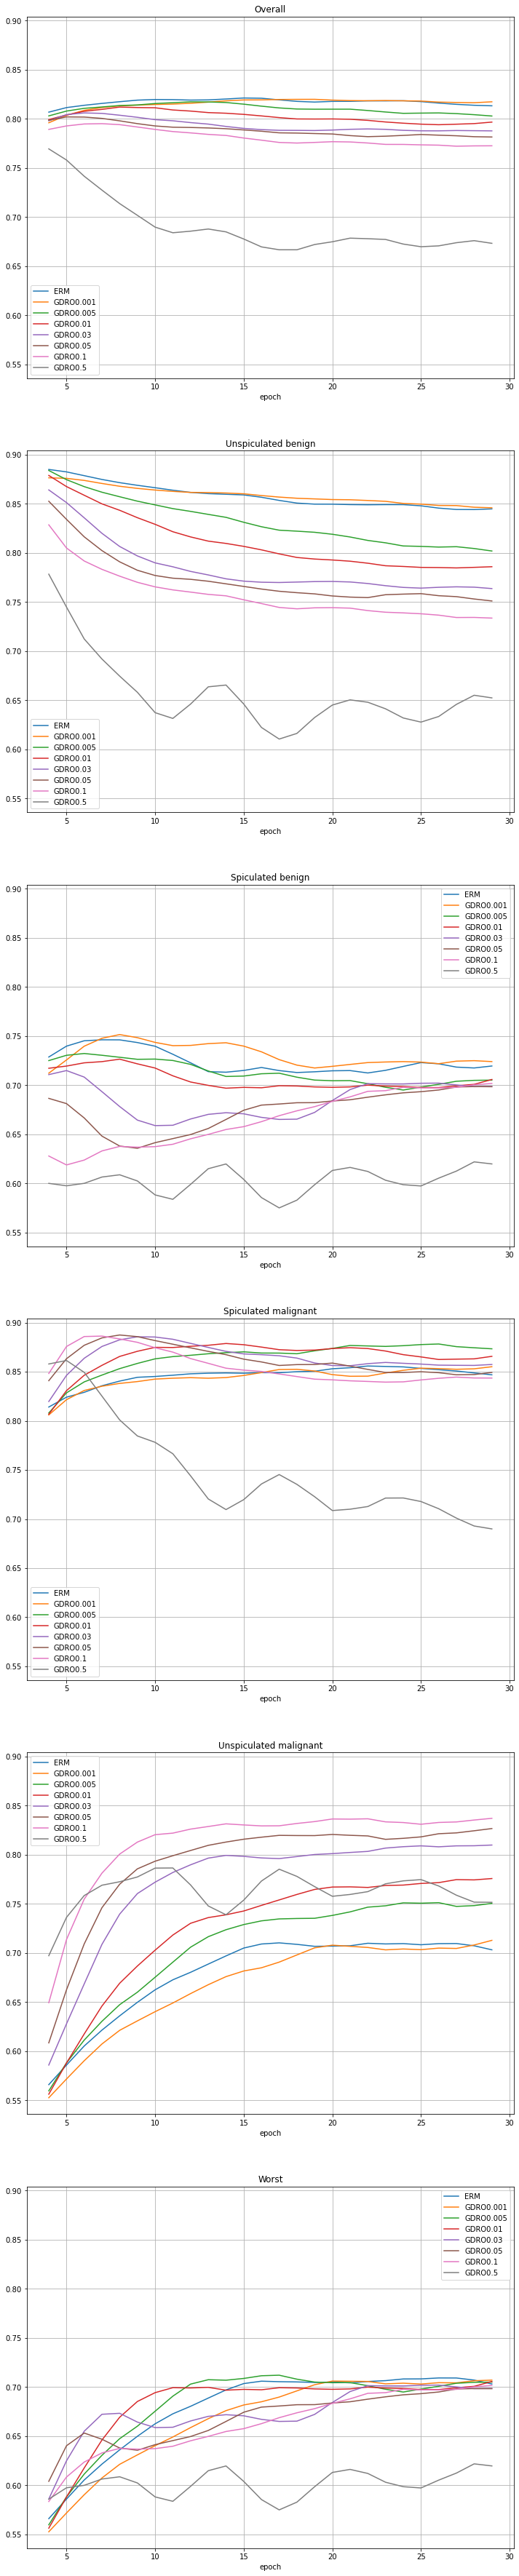

In [161]:
import matplotlib.pyplot as plt

rolling_window = 3

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharey=True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(12,64),grid=True)

# GDRO Demonstration

In [218]:
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]  # no overall needed

epochs = 20
N = 20

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = models.NeuralNetwork(64, 32, 32, 2)
    model.to(device)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

    loss_fn.t = 0.5

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.losses.tolist())

In [219]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

<AxesSubplot:title={'center':'GDRO loss over time (eta=0.05, ERM and GDRO in 1:1 ratio)'}, xlabel='epoch', ylabel='loss'>

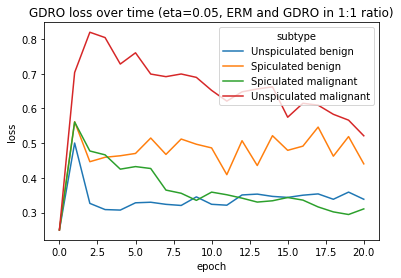

In [220]:
# q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")
q_df.plot(xlabel="epoch", ylabel="loss", title=f"GDRO loss over time (eta={hparams['groupdro_eta']}, ERM and GDRO in 1:1 ratio)")

# Old data

In [ ]:
# data for test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Adaptive", "ExtraERM", "ExtraGDRO", "Halfway"]
# N = 50, epochs = 20
all_data

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0